In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading the dataset**

In [6]:
path = '/content/drive/MyDrive/twcs.csv'

In [7]:
tweetdf = spark.read.csv(path, header = True)

In [8]:
tweetdf.show(100)

+--------------------+--------------+-------+--------------------+--------------------+--------------------+-----------------------+
|            tweet_id|     author_id|inbound|          created_at|                text|   response_tweet_id|in_response_to_tweet_id|
+--------------------+--------------+-------+--------------------+--------------------+--------------------+-----------------------+
|                   1|    sprintcare|  False|Tue Oct 31 22:10:...|@115712 I underst...|                   2|                      3|
|                   2|        115712|   True|Tue Oct 31 22:11:...|@sprintcare and h...|                null|                      1|
|                   3|        115712|   True|Tue Oct 31 22:08:...|@sprintcare I hav...|                   1|                      4|
|                   4|    sprintcare|  False|Tue Oct 31 21:54:...|@115712 Please se...|                   3|                      5|
|                   5|        115712|   True|Tue Oct 31 21:49:...|  @

# **Filtering out all rows with non numeric tweet id (unimportant rows)**

In [9]:
import pyspark.sql
from pyspark.sql import Row
from pyspark.sql.types import *
import json
from pyspark.sql.functions import col
tweetdf1 = tweetdf.filter(col("tweet_id").rlike("^[0-9]*$"))

In [10]:
tweetdf1.show()

+--------+------------+-------+--------------------+--------------------+-----------------+-----------------------+
|tweet_id|   author_id|inbound|          created_at|                text|response_tweet_id|in_response_to_tweet_id|
+--------+------------+-------+--------------------+--------------------+-----------------+-----------------------+
|       1|  sprintcare|  False|Tue Oct 31 22:10:...|@115712 I underst...|                2|                      3|
|       2|      115712|   True|Tue Oct 31 22:11:...|@sprintcare and h...|             null|                      1|
|       3|      115712|   True|Tue Oct 31 22:08:...|@sprintcare I hav...|                1|                      4|
|       4|  sprintcare|  False|Tue Oct 31 21:54:...|@115712 Please se...|                3|                      5|
|       5|      115712|   True|Tue Oct 31 21:49:...|  @sprintcare I did.|                4|                      6|
|       6|  sprintcare|  False|Tue Oct 31 21:46:...|@115712 Can you p...

# **Splitting the dataset based on customer tweet and customer care tweet by checking the numeric value of author_id**

In [11]:
custtweet = tweetdf1.filter(col("author_id").rlike("^[0-9]*$"))

In [12]:
custtweet1 = custtweet.withColumn("tweet_id", custtweet["tweet_id"].cast("Integer"))

In [13]:
print((custtweet1.count(), len(custtweet1.columns)))

(1537853, 7)


In [14]:
custtweet2 = custtweet1.where(custtweet1.text.isNotNull())

In [15]:
custtweet3 = custtweet2.select("tweet_id","created_at","text")

In [16]:
custtweet3.show()

+--------+--------------------+--------------------+
|tweet_id|          created_at|                text|
+--------+--------------------+--------------------+
|       2|Tue Oct 31 22:11:...|@sprintcare and h...|
|       3|Tue Oct 31 22:08:...|@sprintcare I hav...|
|       5|Tue Oct 31 21:49:...|  @sprintcare I did.|
|       8|Tue Oct 31 21:45:...|@sprintcare is th...|
|      12|Tue Oct 31 22:04:...|@sprintcare You g...|
|      16|Tue Oct 31 20:00:...|@sprintcare Since...|
|      18|Tue Oct 31 19:56:...|@115714 y’all lie...|
|      20|Tue Oct 31 22:03:...|@115714 whenever ...|
|      22|Tue Oct 31 22:16:...|@Ask_Spectrum Wou...|
|      26|Tue Oct 31 22:19:...|@Ask_Spectrum I r...|
|      23|Tue Oct 31 22:16:...|@Ask_Spectrum The...|
|      24|Tue Oct 31 22:13:...|@Ask_Spectrum Tha...|
|      29|Tue Oct 31 22:01:...|actually that's a...|
|      31|Tue Oct 31 22:06:...|Yo @Ask_Spectrum,...|
|      33|Tue Oct 31 22:06:...|My picture on @As...|
|      35|Tue Oct 31 22:49:...|@VerizonSupport

In [17]:
caretweet = tweetdf1.subtract(custtweet)

In [18]:
caretweet1 = caretweet.withColumn("in_response_to_tweet_id", caretweet["in_response_to_tweet_id"].cast("Integer"))

In [19]:
caretweet1.show()

+--------+---------------+-------+--------------------+--------------------+-----------------+-----------------------+
|tweet_id|      author_id|inbound|          created_at|                text|response_tweet_id|in_response_to_tweet_id|
+--------+---------------+-------+--------------------+--------------------+-----------------+-----------------------+
|     599|      McDonalds|  False|Tue Oct 31 22:09:...|@115810 Chocolate...|             null|                    487|
|    1178|   VirginTrains|  False|Tue Oct 31 22:18:...|@115920 You'd nee...|             1179|                   1180|
|    1980|    TMobileHelp|  False|Tue Oct 31 23:07:...|@116151 @115913 P...|   1982,1983,1984|                   1978|
|    3296|          Delta|  False|Sat Nov 25 23:23:...|@116477 Please al...|             3295|                   3297|
|    3889|   SpotifyCares|  False|Tue Oct 31 22:39:...|@116649 Hi Nico! ...|             3888|                   3890|
|    4539|    XboxSupport|  False|Tue Oct 31 23:

In [20]:
caretweet2 = caretweet1.select("in_response_to_tweet_id","author_id","created_at")

In [21]:
caretweet3 = caretweet2.withColumnRenamed("author_id","company_name")\
.withColumnRenamed("created_at", "response_time")

# **Joining customer and care tweets based on tweet_id and in_response_to_tweet_id column**

In [22]:
tweetfinal = custtweet3.join(caretweet3, custtweet3.tweet_id == caretweet3.in_response_to_tweet_id, "inner")

In [23]:
tweetfinal.show()

+--------+--------------------+--------------------+-----------------------+--------------+--------------------+
|tweet_id|          created_at|                text|in_response_to_tweet_id|  company_name|       response_time|
+--------+--------------------+--------------------+-----------------------+--------------+--------------------+
|       3|Tue Oct 31 22:08:...|@sprintcare I hav...|                      3|    sprintcare|Tue Oct 31 22:10:...|
|      12|Tue Oct 31 22:04:...|@sprintcare You g...|                     12|    sprintcare|Wed Nov 01 20:48:...|
|      12|Tue Oct 31 22:04:...|@sprintcare You g...|                     12|    sprintcare|Wed Nov 01 20:47:...|
|      12|Tue Oct 31 22:04:...|@sprintcare You g...|                     12|    sprintcare|Tue Oct 31 22:10:...|
|      16|Tue Oct 31 20:00:...|@sprintcare Since...|                     16|    sprintcare|Tue Oct 31 20:03:...|
|      20|Tue Oct 31 22:03:...|@115714 whenever ...|                     20|    sprintcare|Tue O

# **Changing the date time from twitter format to timestamp**

In [24]:
from datetime import datetime
import pytz
from pyspark.sql.functions import udf, to_date, to_utc_timestamp

## Converting date string format
def getDate(x):
    if x is not None:
        return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

## UDF declaration
date_fn = udf(getDate, StringType())

## Converting datatype in spark dataframe
tweetfinal1 = tweetfinal.withColumn("created_at", to_utc_timestamp(date_fn("created_at"),"UTC"))

In [25]:
tweetfinal1 = tweetfinal1.withColumn("response_time", to_utc_timestamp(date_fn("response_time"),"UTC"))

In [26]:
tweetfinal1.show()

+--------+-------------------+--------------------+-----------------------+--------------+-------------------+
|tweet_id|         created_at|                text|in_response_to_tweet_id|  company_name|      response_time|
+--------+-------------------+--------------------+-----------------------+--------------+-------------------+
|       3|2017-10-31 22:08:27|@sprintcare I hav...|                      3|    sprintcare|2017-10-31 22:10:47|
|      12|2017-10-31 22:04:47|@sprintcare You g...|                     12|    sprintcare|2017-11-01 20:48:14|
|      12|2017-10-31 22:04:47|@sprintcare You g...|                     12|    sprintcare|2017-11-01 20:47:40|
|      12|2017-10-31 22:04:47|@sprintcare You g...|                     12|    sprintcare|2017-10-31 22:10:35|
|      16|2017-10-31 20:00:43|@sprintcare Since...|                     16|    sprintcare|2017-10-31 20:03:31|
|      20|2017-10-31 22:03:34|@115714 whenever ...|                     20|    sprintcare|2017-10-31 22:10:10|
|

# **Getting response duration by substracting response time and time of creation of customer tweet**

In [27]:
import pyspark.sql.functions as F
tweetfinal2 = tweetfinal1.withColumn("response_dur", (F.col("response_time").cast("long") - F.col("created_at").cast("long"))/60.)

In [28]:
tweetfinal2.show()

+--------+-------------------+--------------------+-----------------------+--------------+-------------------+------------------+
|tweet_id|         created_at|                text|in_response_to_tweet_id|  company_name|      response_time|      response_dur|
+--------+-------------------+--------------------+-----------------------+--------------+-------------------+------------------+
|       3|2017-10-31 22:08:27|@sprintcare I hav...|                      3|    sprintcare|2017-10-31 22:10:47|2.3333333333333335|
|      12|2017-10-31 22:04:47|@sprintcare You g...|                     12|    sprintcare|2017-11-01 20:48:14|           1363.45|
|      12|2017-10-31 22:04:47|@sprintcare You g...|                     12|    sprintcare|2017-11-01 20:47:40|1362.8833333333334|
|      12|2017-10-31 22:04:47|@sprintcare You g...|                     12|    sprintcare|2017-10-31 22:10:35|               5.8|
|      16|2017-10-31 20:00:43|@sprintcare Since...|                     16|    sprintcare|

# **Installing Afinn library**

In [29]:
!pip install afinn

     |████████████████████████████████| 52 kB 857 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=b9344a8376bf8caf6944663e357050b295a31987215c1d6764ae2b79137d6d84
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [30]:
from afinn import Afinn

In [31]:
afinn = Afinn(language='en')

# **Assigning afinn score (sentiment score) to each tweet in dataset**

In [32]:
tweetfinal3 = tweetfinal2.rdd.map(lambda x : (x[0],x[1],x[2],afinn.score(x[2]),x[3],x[4],x[5],x[6]))\
.toDF()\
.withColumnRenamed("_1","tweet_id")\
.withColumnRenamed("_2","created_at")\
.withColumnRenamed("_3","text")\
.withColumnRenamed("_4","sent_score")\
.withColumnRenamed("_5","in_response_to_tweet_id")\
.withColumnRenamed("_6","company_name")\
.withColumnRenamed("_7","response_time")\
.withColumnRenamed("_8","response_dur")

In [33]:
tweetfinal3.show()

+--------+-------------------+--------------------+----------+-----------------------+--------------+-------------------+------------------+
|tweet_id|         created_at|                text|sent_score|in_response_to_tweet_id|  company_name|      response_time|      response_dur|
+--------+-------------------+--------------------+----------+-----------------------+--------------+-------------------+------------------+
|       3|2017-10-31 22:08:27|@sprintcare I hav...|      -1.0|                      3|    sprintcare|2017-10-31 22:10:47|2.3333333333333335|
|      12|2017-10-31 22:04:47|@sprintcare You g...|       0.0|                     12|    sprintcare|2017-11-01 20:48:14|           1363.45|
|      12|2017-10-31 22:04:47|@sprintcare You g...|       0.0|                     12|    sprintcare|2017-11-01 20:47:40|1362.8833333333334|
|      12|2017-10-31 22:04:47|@sprintcare You g...|       0.0|                     12|    sprintcare|2017-10-31 22:10:35|               5.8|
|      16|201

# **Installing vader sentiment library**

In [34]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 4.2 MB/s 


In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [36]:
analyzer = SentimentIntensityAnalyzer()

In [37]:
analyzer.polarity_scores('Horrible bad day.')

{'compound': -0.7906, 'neg': 0.875, 'neu': 0.125, 'pos': 0.0}

In [38]:
tweetfinal3.select("text").rdd.map(lambda x : analyzer.polarity_scores(x)).take(5)

[{'compound': -0.296, 'neg': 0.145, 'neu': 0.855, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]

# **Adding all the polarity scores to the dataset**

In [39]:
tweetfinal4 = tweetfinal3.rdd.map(lambda x : (x[0],x[1],x[2],analyzer.polarity_scores(x[2]),x[3],x[4],x[5],x[6],x[7]))\
.map(lambda x: (x[0],x[1],x[2],x[3]["neg"],x[3]["pos"],x[3]["neu"],x[3]["compound"],x[4],x[5],x[6],x[7],x[8]))\
.toDF(["tweet_id","created_at","text","neg","pos","neu","compound","sent_score","in_response_to_tweet_id","company_name","response_time","response_dur"])

In [40]:
tweetfinal4.show()

+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+
|tweet_id|         created_at|                text|  neg|  pos|  neu|compound|sent_score|in_response_to_tweet_id|  company_name|      response_time|      response_dur|
+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+
|       3|2017-10-31 22:08:27|@sprintcare I hav...|0.145|  0.0|0.855|  -0.296|      -1.0|                      3|    sprintcare|2017-10-31 22:10:47|2.3333333333333335|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|       0.0|                     12|    sprintcare|2017-11-01 20:48:14|           1363.45|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|       0.0|                     12|    sprintcare|2017-11-01 20:47:40|1362.8833333

In [41]:
#tweetfinal4.describe(['response_dur']).show()

# **Dividing response_dur variable into two categories (<60 min and >= 60 min)**

In [42]:
from pyspark.sql.functions import when
from pyspark.sql.functions import lit
tweetfinal5 = tweetfinal4.withColumn("response_target", when((tweetfinal4.response_dur < 60), lit(0)).otherwise(lit(1)))

In [43]:
tweetfinal5.show()

+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+---------------+
|tweet_id|         created_at|                text|  neg|  pos|  neu|compound|sent_score|in_response_to_tweet_id|  company_name|      response_time|      response_dur|response_target|
+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+---------------+
|       3|2017-10-31 22:08:27|@sprintcare I hav...|0.145|  0.0|0.855|  -0.296|      -1.0|                      3|    sprintcare|2017-10-31 22:10:47|2.3333333333333335|              0|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|       0.0|                     12|    sprintcare|2017-11-01 20:48:14|           1363.45|              1|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|  

In [44]:
tweetfinal5 = tweetfinal5.withColumnRenamed("response_target","label")

In [45]:
#res_tar.show()

# Creation of Pandas dataframe selecting compound and response_dur

In [46]:
tweetcomp = tweetfinal5.select("compound","response_dur")

In [47]:
import pandas as pd
tweetpandas = tweetcomp.toPandas()

In [48]:
compound = tweetpandas['compound']

In [49]:
compound

0         -0.2960
1         -0.5267
2         -0.5267
3         -0.5267
4          0.0000
            ...  
1220331    0.6705
1220332    0.0000
1220333    0.4199
1220334   -0.9255
1220335    0.7500
Name: compound, Length: 1220336, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


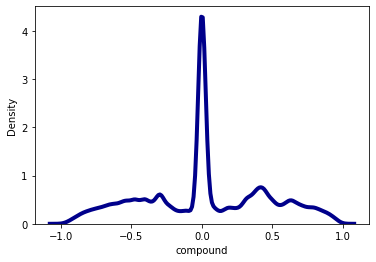

In [50]:
import seaborn as sns
sns.distplot(compound, hist=False, kde=True, bins=50, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},label = 'compound sentiment score')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


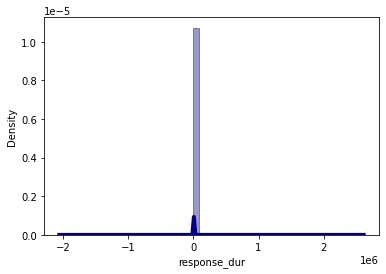

In [51]:
import seaborn as sns
sns.distplot(tweetpandas["response_dur"], hist=True, kde=True, bins=50, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},label = 'response time')

In [52]:
tweetpandas['response_dur'].describe()

count    1.220336e+06
mean     2.881563e+02
std      5.289142e+03
min     -2.052879e+06
25%      6.283333e+00
50%      2.146667e+01
75%      1.082333e+02
max      2.609747e+06
Name: response_dur, dtype: float64

In [53]:
tweetfinal5.describe(['compound']).show()

+-------+--------------------+
|summary|            compound|
+-------+--------------------+
|  count|             1220336|
|   mean|0.022374618301841922|
| stddev|  0.4399329705796217|
|    min|             -0.9992|
|    max|              0.9998|
+-------+--------------------+



In [54]:
tweetfinal5.describe(['response_dur']).show()

+-------+------------------+
|summary|      response_dur|
+-------+------------------+
|  count|           1220336|
|   mean|288.15627909034794|
| stddev| 5289.141652670688|
|    min|       -2052878.85|
|    max|2609746.8333333335|
+-------+------------------+



In [55]:
compound.describe()

count    1.220336e+06
mean     2.237462e-02
std      4.399330e-01
min     -9.992000e-01
25%     -2.960000e-01
50%      0.000000e+00
75%      3.612000e-01
max      9.998000e-01
Name: compound, dtype: float64

# **Checking for normal distribution**

In [56]:
from scipy import stats
stats.normaltest(compound)

NormaltestResult(statistic=46578.00313170772, pvalue=0.0)

In [57]:
from scipy import stats
stats.normaltest(tweetpandas["response_dur"])

NormaltestResult(statistic=6317896.3538639825, pvalue=0.0)

In [58]:
#Data is not normally distributed

# **Vector assembler and pipeline building**

In [59]:
from pyspark.ml.feature import VectorAssembler

In [60]:
vec_assembler = VectorAssembler(inputCols = ['compound'], outputCol = "features")

In [61]:
from pyspark.ml import Pipeline
tweet_pipe = Pipeline(stages=[vec_assembler])

# **Transforming the dataset to get features and labels**

In [62]:
piped_tweet_data = tweet_pipe.fit(tweetfinal5).transform(tweetfinal5)

In [63]:
piped_tweet_data.show()

+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+-----+---------+
|tweet_id|         created_at|                text|  neg|  pos|  neu|compound|sent_score|in_response_to_tweet_id|  company_name|      response_time|      response_dur|label| features|
+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+-----+---------+
|       3|2017-10-31 22:08:27|@sprintcare I hav...|0.145|  0.0|0.855|  -0.296|      -1.0|                      3|    sprintcare|2017-10-31 22:10:47|2.3333333333333335|    0| [-0.296]|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|       0.0|                     12|    sprintcare|2017-11-01 20:48:14|           1363.45|    1|[-0.5267]|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|  

# **Splitting into Train and test**

In [64]:
training, test = piped_tweet_data.randomSplit([0.6,0.4],100)

# **Setting evaluator as Area under AUC**

In [65]:
import pyspark.ml.evaluation as evals
evaluator = evals.BinaryClassificationEvaluator(metricName = "areaUnderROC")

# **Logistic regression model**

In [66]:
#from pyspark.ml.classification import LogisticRegression
#lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
#lrModel = lr.fit(training)
#predictionslr = lrModel.transform(test)

In [67]:
#print(evaluator.evaluate(predictionslr))

In [68]:
#predictionslr.groupBy("prediction").count().show()

In [69]:
#It is predicting everything as zeros

# **Random forest model**

In [70]:
#from pyspark.ml.classification import RandomForestClassifier
#rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
#rfModel = rf.fit(training)
#predictionsrf = rfModel.transform(test)

In [71]:
#print(evaluator.evaluate(predictionsrf))

In [72]:
#predictionsrf.groupBy("prediction").count().show()

In [73]:
#It is predicting both zeros and ones with only very few values as ones

# **Gradient boosting model**

In [74]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features")
gbtModel = gbt.fit(training)
predictionsgbt = gbtModel.transform(test)

In [75]:
print(evaluator.evaluate(predictionsgbt))

0.5145340995632854


In [76]:
predictionsgbt.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|488128|
+----------+------+



In [77]:
#GBT gives highest AUC values

# **Support Vector Machine model**

In [78]:
#from pyspark.ml.classification import LinearSVC
#lsvc = LinearSVC(labelCol="label", featuresCol="features")
#lsvcModel = lsvc.fit(training)
#predictionslsvc = lsvcModel.transform(test)

In [79]:
#print(evaluator.evaluate(predictionslsvc))

In [80]:
#predictionslsvc.groupBy("prediction").count().show()

In [81]:
#Gradient boosting works the best out of all the models

# **Getting the median value of response_dur from our dataset**

In [82]:
tweetfinal5.approxQuantile("response_dur", [0.5], 0.25)

[21.716666666666665]

# **Dividing the response_dur in 2 classes based on median value**

In [83]:
from pyspark.sql.functions import when
from pyspark.sql.functions import lit
tweetfinal7 = tweetfinal4.withColumn("response_target", when((tweetfinal4.response_dur < 21.716), lit(0)).otherwise(lit(1)))

In [84]:
tweetfinal7 = tweetfinal7.withColumnRenamed("response_target","label")

In [85]:
tweetfinal7.show()

+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+-----+
|tweet_id|         created_at|                text|  neg|  pos|  neu|compound|sent_score|in_response_to_tweet_id|  company_name|      response_time|      response_dur|label|
+--------+-------------------+--------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+-----+
|       3|2017-10-31 22:08:27|@sprintcare I hav...|0.145|  0.0|0.855|  -0.296|      -1.0|                      3|    sprintcare|2017-10-31 22:10:47|2.3333333333333335|    0|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|       0.0|                     12|    sprintcare|2017-11-01 20:48:14|           1363.45|    1|
|      12|2017-10-31 22:04:47|@sprintcare You g...|0.167|  0.0|0.833| -0.5267|       0.0|                     12|    sprintcare|20

# **Transforming the dataset to get features and labels**

In [86]:
piped_tweet_data2 = tweet_pipe.fit(tweetfinal7).transform(tweetfinal7)

# **Splitting into Train and test**

In [87]:
training2, test2 = piped_tweet_data2.randomSplit([0.6,0.4],100)

# **Logistic regression model**

In [88]:
#from pyspark.ml.classification import LogisticRegression
#lr2 = LogisticRegression(featuresCol = 'features', labelCol = 'label')
#lrModel2 = lr2.fit(training2)
#predictionslr2 = lrModel2.transform(test2)

In [89]:
#print(evaluator.evaluate(predictionslr2))

In [90]:
#predictionslr2.groupBy("prediction").count().show()

# **Random forest model**

In [91]:
#from pyspark.ml.classification import RandomForestClassifier
#rf2 = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
#rfModel2 = rf2.fit(training2)
#predictionsrf2 = rfModel2.transform(test2)

In [92]:
#print(evaluator.evaluate(predictionsrf2))

In [93]:
#predictionsrf2.groupBy("prediction").count().show()

# **Gradient boosting model**

In [94]:
from pyspark.ml.classification import GBTClassifier
gbt2 = GBTClassifier(labelCol="label", featuresCol="features")
gbtModel2 = gbt2.fit(training2)
predictionsgbt2 = gbtModel2.transform(test2)

In [95]:
print(evaluator.evaluate(predictionsgbt2))

0.5147820071231614


In [96]:
predictionsgbt2.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|294593|
|       1.0|193535|
+----------+------+



# **Support Vector Machine model**

In [97]:
#from pyspark.ml.classification import LinearSVC
#lsvc2 = LinearSVC(labelCol="label", featuresCol="features")
#lsvcModel2 = lsvc2.fit(training2)
#predictionslsvc2 = lsvcModel2.transform(test2)

In [98]:
#print(evaluator.evaluate(predictionslsvc2))

In [99]:
#predictionslsvc2.groupBy("prediction").count().show()

In [100]:
# Here as well, the gradient boosting classifier is the best model with highest AUC value and also able to predict both the classes.

# **Calculating more evaluation metrics for the gbt model**

In [101]:
#import pyspark.ml.evaluation as evals
#evaluator = evals.BinaryClassificationEvaluator(metricName = "areaUnderROC")
#evaluator2 = evals.MulticlassClassificationEvaluator(metricName = "accuracy")
#evaluator3 = evals.MulticlassClassificationEvaluator(metricName = "f1")
#evaluator4 = evals.MulticlassClassificationEvaluator(metricName = "weightedPrecision")
#evaluator5 = evals.MulticlassClassificationEvaluator(metricName = "weightedRecall")

In [102]:
#accuracy
#print(evaluator2.evaluate(predictionsgbt2)) 

In [103]:
#f1
#print(evaluator3.evaluate(predictionsgbt2)) 

In [104]:
#Weighted precision
#print(evaluator4.evaluate(predictionsgbt2)) 

In [105]:
#Weighted recall
#print(evaluator5.evaluate(predictionsgbt2)) 

In [106]:
predictionsgbt2.show()

+--------+-------------------+-------------------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+-----+---------+--------------------+--------------------+----------+
|tweet_id|         created_at|                           text|  neg|  pos|  neu|compound|sent_score|in_response_to_tweet_id|  company_name|      response_time|      response_dur|label| features|       rawPrediction|         probability|prediction|
+--------+-------------------+-------------------------------+-----+-----+-----+--------+----------+-----------------------+--------------+-------------------+------------------+-----+---------+--------------------+--------------------+----------+
|      12|2017-10-31 22:04:47|           @sprintcare You g...|0.167|  0.0|0.833| -0.5267|       0.0|                     12|    sprintcare|2017-11-01 20:48:14|           1363.45|    1|[-0.5267]|[-0.0322348967326...|[0.48388813179980...|       1.0|
|      7

# **Understanding the prediction sentiments**

In [107]:
pred = predictionsgbt2.select("compound","prediction")

In [108]:
predpandas = pred.toPandas()

In [109]:
predpandas.head()

,compound,prediction
0,-0.5267,1.0
1,-0.3595,1.0
2,-0.6551,1.0
3,0.0000,0.0
4,0.0000,0.0


In [110]:
prediction1 = predpandas[predpandas['prediction'] == 1]['compound']
prediction0 = predpandas[predpandas['prediction'] == 0]['compound']

In [111]:
from scipy import stats
stats.normaltest(prediction1)

NormaltestResult(statistic=3285288.091779928, pvalue=0.0)

In [112]:
stats.normaltest(prediction0)

NormaltestResult(statistic=27611.566938567426, pvalue=0.0)

In [113]:
#mannwhitneyu test as both groups are not normally distributed and independent
stats.mannwhitneyu(prediction0,prediction1)

MannwhitneyuResult(statistic=16700351180.0, pvalue=0.0)

In [114]:
#groups are significantly different

In [115]:
prediction1.describe()

count    193535.000000
mean         -0.190844
std           0.491605
min          -0.998700
25%          -0.599400
50%          -0.401900
75%           0.296000
max           0.638100
Name: compound, dtype: float64

In [116]:
prediction0.describe()

count    294593.000000
mean          0.163296
std           0.335143
min          -0.340800
25%           0.000000
50%           0.000000
75%           0.401900
max           0.999400
Name: compound, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density plot for sentiment score of both the classes')

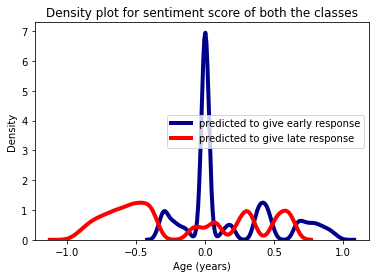

In [117]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.distplot(prediction0, hist=False, kde=True, bins=50, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},label = 'predicted to give early response')
sns.distplot(prediction1, hist=False, kde=True, bins=50, color = 'red', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4}, label = 'predicted to give late response')
plt.xlabel('Age (years)')
plt.legend()
plt.title('Density plot for sentiment score of both the classes')

In [118]:
#predictionsgbt40 = predictionsgbt2.filter(predictionsgbt4.prediction == 0.0) 

In [119]:
#predictionsgbt41 = predictionsgbt2.filter(predictionsgbt4.prediction == 1.0) 

In [120]:
#predictionsgbt40.describe(['compound']).show()

In [121]:
#predictionsgbt41.describe(['compound']).show()

# **Linear regression for the big dataset**

# **Vector assembling and splitting into test and train**

In [122]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler2 = VectorAssembler(inputCols = ['compound'], outputCol = 'features')
tweetfinallin2 = vectorAssembler2.transform(tweetfinal5)
tweetfinallin2 = tweetfinallin2.select(['features', 'response_dur'])
tweetfinallin2.show(5)

+---------+------------------+
| features|      response_dur|
+---------+------------------+
| [-0.296]|2.3333333333333335|
|[-0.5267]|           1363.45|
|[-0.5267]|1362.8833333333334|
|[-0.5267]|               5.8|
|    [0.0]|               2.8|
+---------+------------------+
only showing top 5 rows



In [123]:
splits2 = tweetfinallin2.randomSplit([0.7, 0.3],50)
train_df2 = splits2[0]
test_df2 = splits2[1]

# **Fitting the model**

In [124]:
from pyspark.ml.regression import LinearRegression
linreg2 = LinearRegression(featuresCol = 'features', labelCol='response_dur')
M2 = linreg2.fit(train_df2)
print("Coefficients: " + str(M2.coefficients))
print("Intercept: " + str(M2.intercept))

Coefficients: [23.575888035085345]
Intercept: 286.60349582359595


# **Getting R2 and rmse values**

In [125]:
trainingSummary2 = M2.summary
print("RMSE: %f" % trainingSummary2.rootMeanSquaredError)
print("r2: %f" % trainingSummary2.r2)

RMSE: 5606.067696
r2: 0.000003


# **Getting prediction values**

In [126]:
predictionslinreg2 = M2.transform(test_df2)
predictionslinreg2.select("prediction","response_dur","features").show()

+------------------+------------------+---------+
|        prediction|      response_dur| features|
+------------------+------------------+---------+
| 263.2515787248439|1714.3833333333334|[-0.9905]|
| 263.3175912113422|              73.6|[-0.9877]|
|263.35059745459125|63.583333333333336|[-0.9863]|
| 263.4071795858755| 8.116666666666667|[-0.9839]|
|263.47083448357023|139.51666666666668|[-0.9812]|
| 263.5085559044263|              2.65|[-0.9796]|
|263.56513803571056|               3.2|[-0.9772]|
|263.56749562451404|160.16666666666666|[-0.9771]|
| 263.5745683909246|             137.9|[-0.9768]|
|263.60050186776317|             24.35|[-0.9757]|
| 263.6287929334053|2.5833333333333335|[-0.9745]|
|263.64765364383334|46.333333333333336|[-0.9737]|
| 263.6735871206719| 97.93333333333334|[-0.9726]|
| 263.7089509527246| 7.233333333333333|[-0.9711]|
| 263.7183813079386| 87.03333333333333|[-0.9707]|
| 263.7230964855456|47.916666666666664|[-0.9705]|
| 263.7490299623842| 96.28333333333333|[-0.9694]|


In [127]:
predictionslinreg2.describe(['prediction']).show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|            366078|
|   mean| 287.1457099624558|
| stddev|10.368590386161761|
|    min|263.09362027500885|
|    max|310.17466868107425|
+-------+------------------+

